In [1]:
import numpy as np
import torch
from connectivity_representation_learning import *

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # unused import, required by projection='3d'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Generate 2D Gaussian mixture data

In [2]:
# dimension
d = 2
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [3]:
config_layers = {
    'type': 'mlp',
    'input_size': data.shape[1],
    'hidden_size_encoder': 64,
    'hidden_size_decoder': 64,
    'emb_size': 2,
}

use_cuda = False

# eta = barcode_stats(data)[2]
# print('eta={:.2f}'.format(eta))
eta = 2.0

tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 15

eta=2.70


### Training

In [4]:
model_no_penalty = Model(config_layers, 
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)
torch.save(model_no_penalty.state_dict(), 'gauss_2d_{}_epochs_no_penalty.pt'.format(n_epochs))

model_penalty = Model(config_layers, 
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)
torch.save(model_penalty.state_dict(), 'gauss_2d_{}_epochs_penalty.pt'.format(n_epochs))

Epoch : 1/15: 100%|█| 30.0/30.0 [00:00<00:00, 420it/s, connectivity loss=0, reconstruction loss=8.13]
Epoch : 2/15: 100%|█| 30.0/30.0 [00:00<00:00, 436it/s, connectivity loss=0, reconstruction loss=4.13]
Epoch : 3/15: 100%|█| 30.0/30.0 [00:00<00:00, 366it/s, connectivity loss=0, reconstruction loss=1.56]
Epoch : 4/15: 100%|█| 30.0/30.0 [00:00<00:00, 381it/s, connectivity loss=0, reconstruction loss=0.239]
Epoch : 5/15: 100%|█| 30.0/30.0 [00:00<00:00, 387it/s, connectivity loss=0, reconstruction loss=0.0653]
Epoch : 6/15: 100%|█| 30.0/30.0 [00:00<00:00, 373it/s, connectivity loss=0, reconstruction loss=0.0212]
Epoch : 7/15: 100%|█| 30.0/30.0 [00:00<00:00, 416it/s, connectivity loss=0, reconstruction loss=0.0101]
Epoch : 8/15: 100%|█| 30.0/30.0 [00:00<00:00, 446it/s, connectivity loss=0, reconstruction loss=0.00848]
Epoch : 9/15: 100%|█| 30.0/30.0 [00:00<00:00, 430it/s, connectivity loss=0, reconstruction loss=0.00774]
Epoch : 10/15: 100%|█| 30.0/30.0 [00:00<00:00, 409it/s, connectivity 

### Results

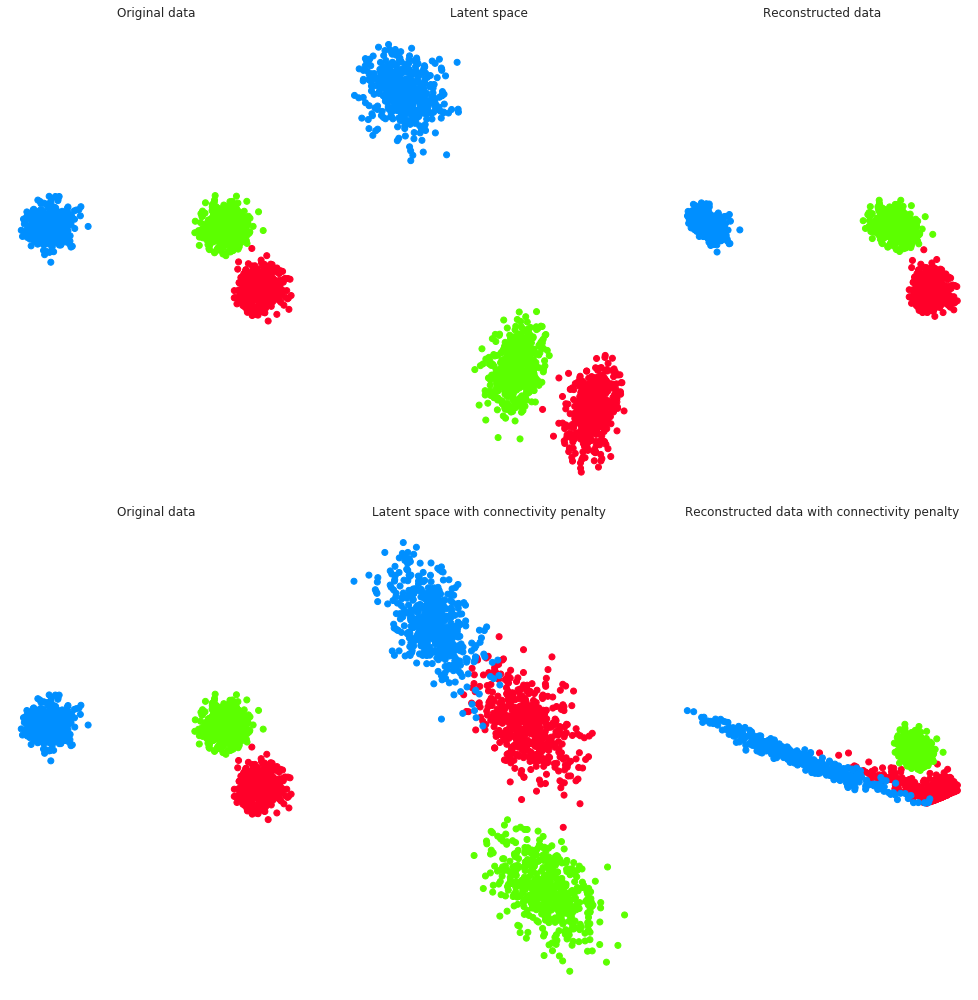

[0.00069546734, 0.03801456525216029, 2.6969588]
[0.00078448805, 0.03840688103592499, 2.5073607]
[0.0054566003, 0.26391754252183747, 2.183263]


In [5]:
fig, axes = plt.subplots(figsize=(14, 14), nrows=2, ncols=3)

ax = axes[0, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[0, 1]
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')
ax.axis('off')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data')
ax.axis('off')

ax = axes[1, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[1, 1]
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')
ax.axis('off')

ax = axes[1, 2]
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty')
ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('gaussian.eps')

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))

### Generate 3D Gaussian mixture data

In [6]:
# dimension
d = 3
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [7]:
config_layers = {
    'type': 'mlp',
    'input_size': data.shape[1],
    'hidden_size_encoder': 20,
    'hidden_size_decoder': 20,
    'emb_size': 2,
}

use_cuda = False

eta = barcode_stats(data)[2]
print('eta={:.2f}'.format(eta))

tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 15

eta=9.33


### Training

In [8]:
model_no_penalty = Model(config_layers, 
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)
# torch.save(model_no_penalty.state_dict(), 'gauss_3d_{}_epochs_no_penalty.pt'.format(n_epochs))

model_penalty = Model(config_layers, 
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)
# torch.save(model_penalty.state_dict(), 'gauss_3d_{}_epochs_penalty.pt'.format(n_epochs))

Epoch : 1/15: 100%|█| 30.0/30.0 [00:00<00:00, 469it/s, connectivity loss=0, reconstruction loss=10.4]
Epoch : 2/15: 100%|█| 30.0/30.0 [00:00<00:00, 499it/s, connectivity loss=0, reconstruction loss=8.34]
Epoch : 3/15: 100%|█| 30.0/30.0 [00:00<00:00, 490it/s, connectivity loss=0, reconstruction loss=5.51]
Epoch : 4/15: 100%|███| 30.0/30.0 [00:00<00:00, 435it/s, connectivity loss=0, reconstruction loss=4] 
Epoch : 5/15: 100%|█| 30.0/30.0 [00:00<00:00, 438it/s, connectivity loss=0, reconstruction loss=2.8] 
Epoch : 6/15: 100%|█| 30.0/30.0 [00:00<00:00, 455it/s, connectivity loss=0, reconstruction loss=1.16]
Epoch : 7/15: 100%|█| 30.0/30.0 [00:00<00:00, 442it/s, connectivity loss=0, reconstruction loss=0.511]
Epoch : 8/15: 100%|█| 30.0/30.0 [00:00<00:00, 426it/s, connectivity loss=0, reconstruction loss=0.428]
Epoch : 9/15: 100%|█| 30.0/30.0 [00:00<00:00, 433it/s, connectivity loss=0, reconstruction loss=0.394]
Epoch : 10/15: 100%|█| 30.0/30.0 [00:00<00:00, 430it/s, connectivity loss=0, re

### Results

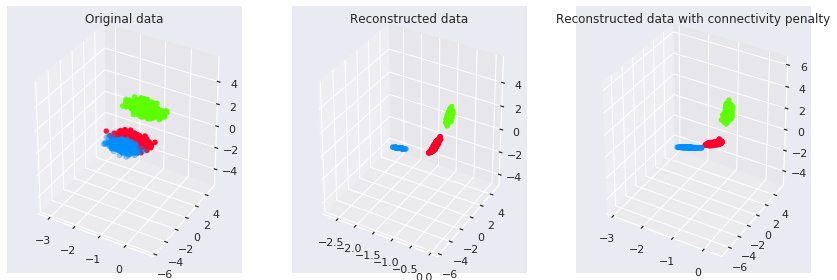

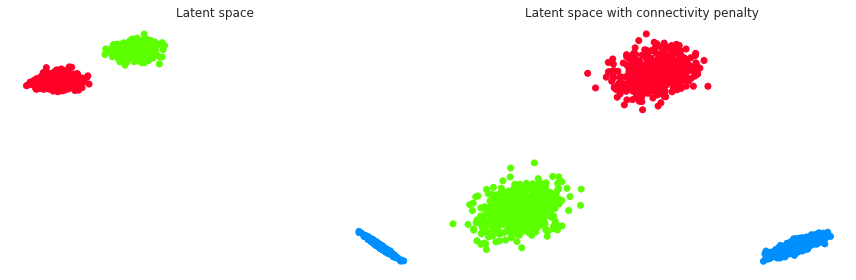

[0.005414989, 0.10254732810154686, 9.328487]
[0.00015882186, 0.028199308470458172, 8.100136]
[0.00082072784, 0.10501428442529395, 8.223131]


In [9]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(data[:, 0], data[:, 1],  data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Original data')

ax = fig.add_subplot(132, projection='3d')
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1],  reconstructed_data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Reconstructed data')

ax = fig.add_subplot(133, projection='3d')
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1],  reconstructed_data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Reconstructed data with connectivity penalty')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')
ax.axis('off')

ax = fig.add_subplot(122)
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')
ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('gaussian_3d.eps')

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))